In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


# Fake news detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/fake-news-master/data/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/fake-news-master/data/True.csv')
# fake = pd.read_csv('/content/Fake.csv')
# true = pd.read_csv('/content/True.csv')

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [ ]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,title,text,subject,date,target
0,SHOUT! POLL: Who Do You Trust with Foreign Pol...,21st Century Wire asks HAVE YOUR SHOUT: We ask...,US_News,"May 8, 2016",fake
1,BLACK TRUMP SUPPORTER Goes On Tirade Over CNN’...,"On June 10, people in at least 27 cities are g...",politics,"Jun 10, 2017",fake
2,Britain's Johnson says as May heads to Brussel...,LUXEMBOURG (Reuters) - Britain s Foreign Secre...,worldnews,"October 16, 2017",true
3,Trump says he will hold a news conference Janu...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"January 4, 2017",true
4,"U.N. watchdog tells Congo to hold election, cl...",GENEVA (Reuters) - The U.N. Human Rights Commi...,worldnews,"November 9, 2017",true


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,SHOUT! POLL: Who Do You Trust with Foreign Pol...,21st Century Wire asks HAVE YOUR SHOUT: We ask...,US_News,fake
1,BLACK TRUMP SUPPORTER Goes On Tirade Over CNN’...,"On June 10, people in at least 27 cities are g...",politics,fake
2,Britain's Johnson says as May heads to Brussel...,LUXEMBOURG (Reuters) - Britain s Foreign Secre...,worldnews,true
3,Trump says he will hold a news conference Janu...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,true
4,"U.N. watchdog tells Congo to hold election, cl...",GENEVA (Reuters) - The U.N. Human Rights Commi...,worldnews,true


In [ ]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,21st Century Wire asks HAVE YOUR SHOUT: We ask...,US_News,fake
1,"On June 10, people in at least 27 cities are g...",politics,fake
2,LUXEMBOURG (Reuters) - Britain s Foreign Secre...,worldnews,true
3,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,true
4,GENEVA (Reuters) - The U.N. Human Rights Commi...,worldnews,true


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,21st century wire asks have your shout: we ask...,US_News,fake
1,"on june 10, people in at least 27 cities are g...",politics,fake
2,luxembourg (reuters) - britain s foreign secre...,worldnews,true
3,(reuters) - u.s. president-elect donald trump ...,politicsNews,true
4,geneva (reuters) - the u.n. human rights commi...,worldnews,true


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
# Check
data.head()

,text,subject,target
0,21st century wire asks have your shout we ask ...,US_News,fake
1,on june 10 people in at least 27 cities are ga...,politics,fake
2,luxembourg reuters britain s foreign secretar...,worldnews,true
3,reuters us presidentelect donald trump said o...,politicsNews,true
4,geneva reuters the un human rights committee ...,worldnews,true


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,text,subject,target
0,21st century wire asks shout ask readers trust...,US_News,fake
1,june 10 people least 27 cities gathering march...,politics,fake
2,luxembourg reuters britain foreign secretary b...,worldnews,true
3,reuters us presidentelect donald trump said tw...,politicsNews,true
4,geneva reuters un human rights committee thurs...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


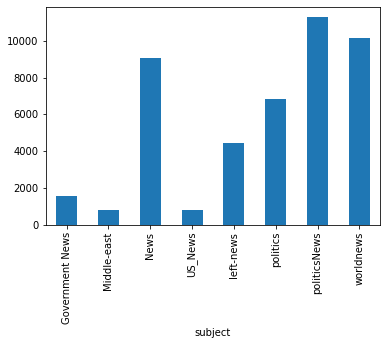

In [ ]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


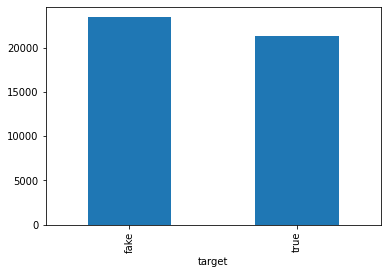

In [ ]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

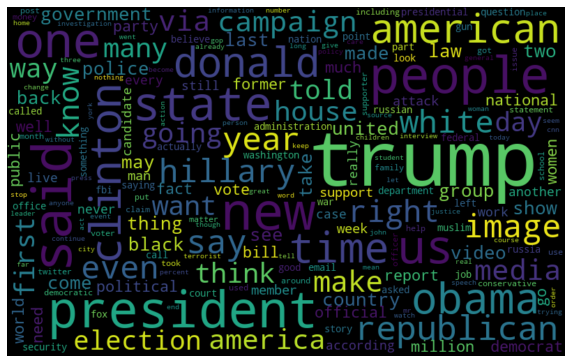

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

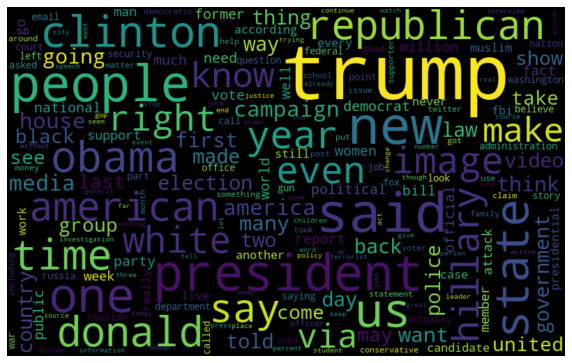

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

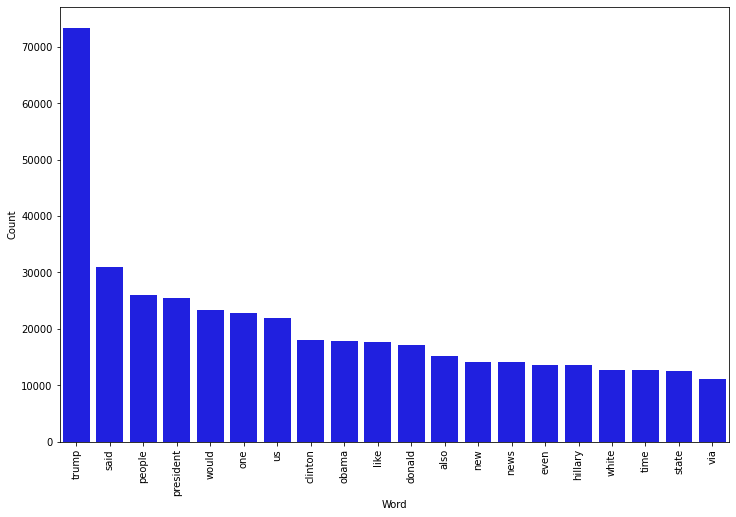

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

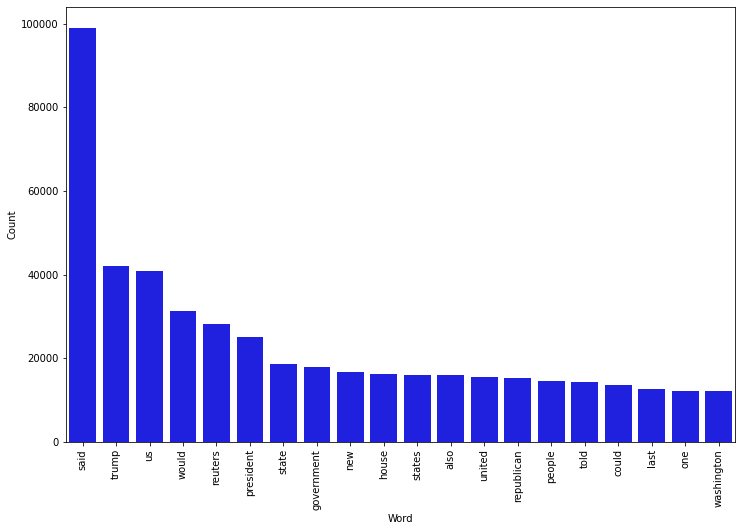

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.4, random_state=44)

### Logistic regression

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.71%


Confusion matrix, without normalization


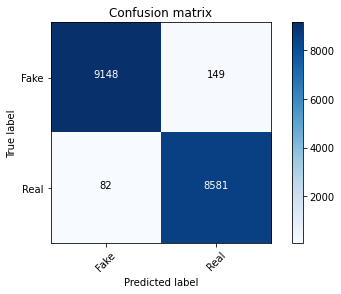

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
print(classification_report(prediction,y_test))

              precision    recall  f1-score   support

        fake       0.98      0.99      0.99      9230
        true       0.99      0.98      0.99      8730

    accuracy                           0.99     17960
   macro avg       0.99      0.99      0.99     17960
weighted avg       0.99      0.99      0.99     17960



### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy'))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.48%


Confusion matrix, without normalization


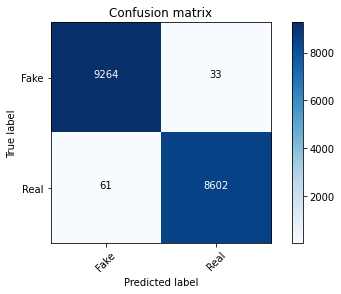

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
print(classification_report(prediction,y_test))

              precision    recall  f1-score   support

        fake       1.00      0.99      0.99      9325
        true       0.99      1.00      0.99      8635

    accuracy                           0.99     17960
   macro avg       0.99      0.99      0.99     17960
weighted avg       0.99      0.99      0.99     17960



### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.69%


Confusion matrix, without normalization


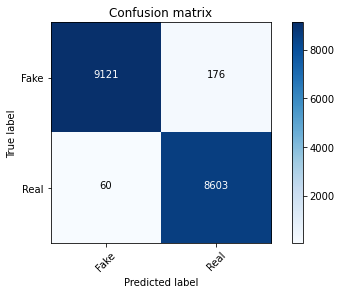

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
print(classification_report(prediction,y_test))

              precision    recall  f1-score   support

        fake       0.98      0.99      0.99      9181
        true       0.99      0.98      0.99      8779

    accuracy                           0.99     17960
   macro avg       0.99      0.99      0.99     17960
weighted avg       0.99      0.99      0.99     17960



# **SVM**

In [ ]:
from sklearn.svm import LinearSVC

# Vectorizing and applying TF-IDF
pipe_svm = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])
# Fitting the model
model = pipe_svm.fit(X_train, y_train)

# Accuracy
prediction_svm = model.predict(X_test)

Confusion matrix, without normalization


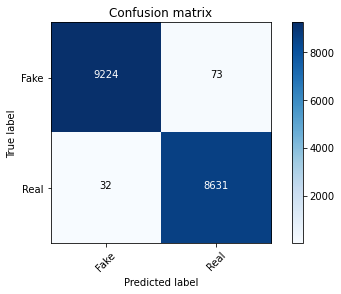

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction_svm)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
print(classification_report(prediction_svm,y_test))

              precision    recall  f1-score   support

        fake       0.99      1.00      0.99      9256
        true       1.00      0.99      0.99      8704

    accuracy                           0.99     17960
   macro avg       0.99      0.99      0.99     17960
weighted avg       0.99      0.99      0.99     17960

